# 🎮 Kontrol Metal Slug dengan Gestur Tangan

Notebook ini digunakan untuk menghubungkan deteksi gestur tubuh melalui MediaPipe dengan aksi keyboard dalam permainan Metal Slug. Dengan menggunakan kamera dan pustaka MediaPipe, kita dapat mengenali berbagai gerakan tubuh, seperti:

- Mengangkat tangan untuk menembak
- Melempar granat
- Melompat
- Jalan maju/mundur
- Menunduk

Seluruh gerakan ini dikonversi menjadi input keyboard agar karakter dalam game dapat dikendalikan tanpa menyentuh keyboard secara manual.

### 📋 Tabel Gesture dan Tombol

| Gesture           | Tombol                  | Penjelasan                                                     |
| ----------------- | ----------------------- | -------------------------------------------------------------- |
| 🤚 Idle           | `None`                  | Diam, tidak ada aksi                                           |
| ✋ Jalan / Maju    | `Arrow Right`           | Angkat tangan kiri lurus ke depan                              |
| 🫲 Arah Maju      | `-` (DPAD/Arrow)        | Gerakan kepala ke kanan digunakan saat ingin maju              |
| 🔫 Shoot          | `x`                     | Tangan kanan mengarah ke depan seperti memegang pistol         |
| 💣 Grenade        | `s`                     | Gerakan melempar dari belakang ke depan dengan tangan kanan    |
| 🔫⬆️ Shoot Upward | `Arrow Up + x`          | Tangan mengarah ke atas sambil posisi pistol                   |
| 🔽 Crouch         | `Arrow Down`            | Kepala menunduk hingga hidung lebih rendah dari posisi telinga |
| 🦘 Jump           | `z`                     | Lompat hingga posisi pundak keluar dari frame                  |


# Deteksi Gesture

Notebook ini digunakan untuk mendeteksi gesture dari gambar yang diunggah menggunakan MediaPipe. Ada beberapa gesture yang sudah terimplementasi, yaitu:
- **Menembak** → ditekan tombol `x`
- **Melempar Grenade** → ditekan tombol `s`


In [1]:

!pip install mediapipe opencv-python


# Import Module

In [2]:

import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display
import io
from PIL import Image
from google.colab import files


# Mengunggah gambar untuk dideteksi

In [25]:

uploaded = files.upload()
image = None

for fn in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[fn]))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    print(f"Gambar '{fn}' berhasil dimuat.")


Saving Screenshot 2025-06-15 030715.png to Screenshot 2025-06-15 030715.png
Gambar 'Screenshot 2025-06-15 030715.png' berhasil dimuat.


# Proses deteksi gesture

In [26]:
# Inisialisasi MediaPipe
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.7)

def detect_gesture(image):
    h, w = image.shape[:2]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Proses tangan
    hand_results = hands.process(image_rgb)
    # Proses pose (untuk deteksi kepala & jump)
    pose_results = pose.process(image_rgb)

    annotated_image = image.copy()
    action = "tidak terdeteksi"
    key = "-"

    # ========================
    # Deteksi gesture tangan
    # ========================
    if hand_results.multi_hand_landmarks:
        for hand_landmarks in hand_results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            landmarks = hand_landmarks.landmark

            # Variabel untuk deteksi gesture original
            wrist_y = landmarks[0].y * h
            index_y = landmarks[8].y * h
            middle_y = landmarks[12].y * h
            wrist_x = landmarks[0].x * w

            # Variabel untuk shooting upward gesture
            wrist_upward = landmarks[0]
            index_tip_upward = landmarks[8]
            index_mcp_upward = landmarks[5]
            middle_tip_upward = landmarks[12]
            ring_tip_upward = landmarks[16]
            pinky_tip_upward = landmarks[20]

            wrist_y_upward = wrist_upward.y * h
            index_y_upward = index_tip_upward.y * h
            index_vector_y_upward = index_tip_upward.y - index_mcp_upward.y
            middle_y_upward = middle_tip_upward.y * h
            ring_y_upward = ring_tip_upward.y * h
            pinky_y_upward = pinky_tip_upward.y * h

            # Deteksi shooting upward gesture
            hand_high_upward = wrist_y_upward < h * 0.6
            index_pointing_up_upward = index_vector_y_upward < -0.05
            fingers_bent_upward = sum([
                middle_y_upward > index_y_upward + 10,
                ring_y_upward > index_y_upward + 10,
                pinky_y_upward > index_y_upward + 10
            ]) >= 2

            if hand_high_upward and index_pointing_up_upward and fingers_bent_upward:
                action = "shoot_up"
                key = "Arrow Up, x"
                return annotated_image, action, key
            elif wrist_y < h * 0.6 and index_y < wrist_y and abs(index_y - middle_y) > 20:
                action = "shoot"
                key = "x"
            elif wrist_x > w * 0.7 and wrist_y < h * 0.5:
                action = "grenade"
                key = "s"

    # ========================
    # Deteksi kepala dan jump
    # ========================
    if pose_results.pose_landmarks:
        mp_drawing.draw_landmarks(annotated_image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        landmarks = pose_results.pose_landmarks.landmark

        nose = landmarks[mp_pose.PoseLandmark.NOSE]
        left_ear = landmarks[mp_pose.PoseLandmark.LEFT_EAR]
        right_ear = landmarks[mp_pose.PoseLandmark.RIGHT_EAR]
        left_eye = landmarks[mp_pose.PoseLandmark.LEFT_EYE_INNER]
        right_eye = landmarks[mp_pose.PoseLandmark.RIGHT_EYE_INNER]

        nose_x = nose.x * w
        nose_y = nose.y * h
        left_ear_x = left_ear.x * w
        right_ear_x = right_ear.x * w

        left_ear_y = left_ear.y * h
        right_ear_y = right_ear.y * h

        right_eye_y = right_eye.y * h
        left_eye_y = left_eye.y * h

        # Tambahan deteksi gesture jump
        left_wrist_y = landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y * h
        right_wrist_y = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y * h
        shoulder_y = (
            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y +
            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y
        ) / 2 * h

        if left_wrist_y < shoulder_y and right_wrist_y < shoulder_y:
            action = "jump"
            key = "z"

        else:
          dist_left = abs(nose_x - left_ear_x)
          dist_right = abs(nose_x - right_ear_x)
          eye_avg_y = (left_eye_y + right_eye_y) / 2
          ear_avg_y = (left_ear_y + right_ear_y) / 2

          if dist_right < dist_left and eye_avg_y >= ear_avg_y:
              action = "turning_right_down"
              key = "Arrow Right, Arrow Down"
          elif dist_left < dist_right and eye_avg_y >= ear_avg_y:
              action = "turning_left_down"
              key = "Arrow Left, Arrow Down"
          elif dist_right < dist_left:
              action = "turning_right"
              key = "Arrow Right"
          elif dist_left < dist_right:
              action = "turning_left"
              key = "Arrow Left"
          elif nose_y > ear_avg_y + 20:
              action = "head_down"
              key = "Arrow Down"

    return annotated_image, action, key

Gesture terdeteksi: jump, tombol yang ditekan adalah: z


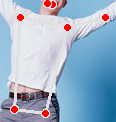

In [27]:
if image is not None:
    annotated, gesture, key = detect_gesture(image)
    print(f"Gesture terdeteksi: {gesture}, tombol yang ditekan adalah: {key}")
    cv2_imshow(annotated)

| Gesture           | Tombol                  | Penjelasan                                                     |
| ----------------- | ----------------------- | -------------------------------------------------------------- |
| 🤚 Idle           | `None`                  | Diam, tidak ada aksi                                           |
| ✋ Jalan / Maju    | `Arrow Right`           | Angkat tangan kiri lurus ke depan                              |
| 🫲 Arah Maju      | `-` (DPAD/Arrow) | Gerakan kepala ke kanan digunakan saat ingin maju              |
| 🔫 Shoot          | `x`                     | Tangan kanan mengarah ke depan seperti memegang pistol         |
| 💣 Grenade        | `s`                     | Gerakan melempar dari belakang ke depan dengan tangan kanan                      |
| 🔫⬆️ Shoot Upward | `Arrow Up + x`          | Tangan mengarah ke atas sambil posisi pistol                   |
| 🔽 Crouch         | `Arrow Down`            | Kepala menunduk hingga hidung lebih rendah dari posisi telinga |
| 🦘 Jump           | `z`                     | Lompat hingga posisi pundak keluar dari frame                            |
